In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Point is always the x, y coordinate of object and anlge of rotation of its frame

def cvt_local2global(local_point, sc_point):
    point = np.zeros(3)
    x, y, a = local_point
    X, Y, A = sc_point
    point[0] = x * np.cos(A) - y * np.sin(A) + X
    point[1] = x * np.sin(A) + y * np.cos(A) + Y
    point[2] = a + A
    return point

def cvt_global2local(global_point, sc_point):
    point = np.zeros(3)
    x, y, a = global_point
    X, Y, A = sc_point
    point[0] = x * np.cos(A) + y * np.sin(A) - X * np.cos(A) - Y * np.sin(A)
    point[1] = -x * np.sin(A) + y * np.cos(A) + X * np.sin(A) - Y * np.cos(A)
    point[2] = a - A
    return point 

In [6]:
class TrackRegulator(object):
    def __init__(self):
        self.MAX_VELOCITY = 0.57
        self.MAX_ROTATION = 3.14
        self.MIN_VELOCITY = 0.03
        self.MIN_ROTATION = 0.15
        self.NORM_ANGLE = 3.14 / 4
        self.NORM_DISTANCE = 0.1
        self.target_point = np.zeros(3)
        self.is_rotate = False
        self.is_move_forward = False
        self.is_moving = False
    
    def start_rotate(self, point):
        print("Start rotate")
        da = (self.target_point[2] - point[2]) % (2 * np.pi)
        if da < np.pi:
            self.rotation_diraction = 1
            self.dangle = da
        else:
            self.rotation_diraction = -1
            self.dangle = 2 * np.pi - da
        self.start_angle = point[2]
        self.is_rotate = True
        
    def start_move_forward(self, point):
        print("Start move forward")
        self.is_rotate = False
        self.is_move_forward = True
        self.distance = np.sum((self.target_point[:2] - point[:2]) ** 2) ** 0.5
        
        self.start_to_target_point = np.zeros(3)
        self.start_to_target_point[:2] = point[:2]
        dp = self.target_point[:2] - point[:2]
        self.start_to_target_point[2] = np.arctan2(dp[1], dp[0])
           
    def start_move(self, target_point, point):
        print("Start move")
        self.target_point = target_point
        self.start_rotate(point)

    def rotate(self, point):
        da = (point[2] - self.start_angle) * self.rotation_diraction
        
        if da > self.dangle:
            self.start_move_forward(point)
            return np.zeros(3)
        elif da > self.dangle - self.NORM_ANGLE:
            v_angle = (self.dangle - da) / self.NORM_ANGLE * self.MAX_ROTATION / 2 + self.MIN_ROTATION
        elif da < self.NORM_ANGLE:
            v_angle = da / self.NORM_ANGLE * self.MAX_ROTATION / 2
        else:
            v_angle = self.MAX_ROTATION / 2
        print("v_angle", v_angle + self.MIN_ROTATION)
        return np.array([0, 0, self.rotation_diraction * (v_angle + self.MIN_ROTATION)])
    
    def move(self, point):
        point_in_target_system = cvt_global2local(point, self.start_to_target_point)
        dx = point_in_target_system[0]
        if dx > self.distance:
            self.is_move_forward = False
            self.is_moving = False
            return np.zeros(3)
        elif dx > self.distance - self.NORM_DISTANCE:
            v = (self.distance - dx) / self.NORM_DISTANCE * self.MAX_VELOCITY / 2 + self.MIN_VELOCITY
        elif dx < self.NORM_DISTANCE:
            v = dx / self.NORM_DISTANCE * self.MAX_VELOCITY / 2
        else:
            v = self.MAX_VELOCITY / 2
        v += self.MIN_VELOCITY
        v_x = v * np.cos(self.start_to_target_point[2] - point[2])
        v_y = v * np.sin(self.start_to_target_point[2] - point[2])
        return np.array([v_x, v_y, 0])
        
    def regulate(self, point):
        if self.is_rotate:
            return self.rotate(point)
        elif self.is_move_forward:
            return self.move(point)
        else:
            return np.zeros(3)
        
class EncoderIntegrator(object):
    def __init__(self, start_point):
        self.last_point = start_point
    def integrate(self, dpoint):
        self.last_point = cvt_local2global(dpoint, self.last_point)
        return self.last_point

Start move
Start rotate
Start move forward


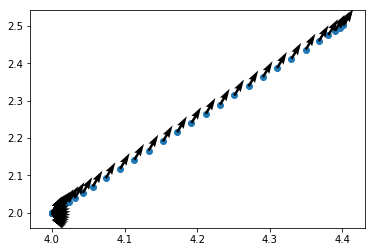

In [23]:
start_point = np.array([4, 2, -1])
dt = 0.1

tr_regulator = TrackRegulator()
enc_integrator = EncoderIntegrator(start_point)
tr_regulator.start_move(np.array([4.4, 2.5, 1]), start_point)
points = [start_point]
point = start_point
while tr_regulator.is_move_forward or tr_regulator.is_rotate:
    v = tr_regulator.regulate(point)
    point = enc_integrator.integrate(v * dt)
    points.append(point)
#    print(point)
    
points = np.array(points)
plt.scatter(points.T[0], points.T[1])
plt.quiver(points.T[0], points.T[1], np.cos(points.T[2]), np.sin(points.T[2]))

In [1]:
import serial
import struct
import datetime
import time

class STMprotocol:
    def __init__(self, serial_port):
        self.ser = serial.Serial(serial_port, 115200, timeout=0.2)
        self.pack_format = {
            0x01: "=BBBB",
            0x03: "=Bf",
            0x04: "=B",
            0x05: "=B",
            0x06: "=Bffff",
            0x07: "=B",
            0x08: "=fff",
            0x09: "=",
            0x0b: "=BH",
            0x0c: "=B",
            0x0D: "=B",
            
            0xa0: "=fff",
            0xa1: "=fff",
            0x0a: "="
        }

        self.unpack_format = {
            0x01: "=BBBB",
            0x03: "=BB",
            0x04: "=BB",
            0x05: "=BB",
            0x06: "=BB",
            0x07: "=ffff",
            0x08: "=BB",
            0x09: "=fff",
            0x0b: "=BB",
            0x0c: "=f",
            0x0D: "=BB",
            
            0xa0: "=Bfff",
            0xa1: "=BB",
            0x0a: "=fff"
        }

    def send_command(self, cmd, args):
        # Clear buffer
        #print(self.ser.read(self.ser.inWaiting()))
        
        parameters = bytearray(struct.pack(self.pack_format[cmd], *args))
        #print(parameters)
        msg_len = len(parameters) + 5
        msg = bytearray([0xfa, 0xaf, msg_len, cmd]) + parameters
        crc = sum(msg) % 256
        msg += bytearray([crc])

        #print("send ", repr(msg))
        self.ser.write(msg)

        start_time = datetime.datetime.now()
        time_threshold = datetime.timedelta(seconds=1)
        dt = start_time - start_time
        
        time.sleep(0.001)
        data = self.ser.read()[0]
        while (data != 0xfa) and (dt < time_threshold):
            data = self.ser.read()[0]

            current_time = datetime.datetime.now()
            dt = start_time - current_time

        adr = self.ser.read()[0]
        answer_len = self.ser.read()[0]
        answer = bytearray(self.ser.read(answer_len - 3))
        #print("answer ", repr(bytearray([data, adr, answer_len]) + answer))

        args = struct.unpack(self.unpack_format[cmd], answer[1:-1])
        return args


In [2]:
protocol = STMprotocol("COM8")

In [3]:
# Echo
protocol.send_command(0x01, [ord(c) for c in 'ECHO'])

(69, 67, 72, 79)

In [11]:
start_point = np.array([0, 0, 0])
dt = 0.02

tr_regulator = TrackRegulator()
enc_integrator = EncoderIntegrator(start_point)
tr_regulator.start_move(np.array([0, 0, np.pi]), start_point)
points = [start_point]
point = start_point
print(point)
prev_time = time.time()
start_time = time.time()
a0 = 0
while tr_regulator.is_move_forward or tr_regulator.is_rotate:
    v = tr_regulator.regulate(point)
    #Send velocity
    timer_2 = time.time()
    protocol.send_command(0x08, list(v))
    print("timer 1", time.time() - timer_2)
    
    time.sleep(dt)
    
    #Recieve feedback
    timer_1 = time.time()
    v  = protocol.send_command(0x0a, [])
    print("timer 2", time.time() - timer_1)
#     cur_time = time.time()
#     a0 += v[2] * (cur_time - prev_time)
#     prev_time = time.time()
    cur_time = time.time()
    point = enc_integrator.integrate(0.8 * np.array(v))
    print("delta time", cur_time - prev_time)
    prev_time = time.time()
    points.append(point)
    print(point)
    print("a000000", a0)

Start move
Start rotate
[0 0 0]
v_angle 0.15
timer 1 0.0035092830657958984
timer 2 0.0039975643157958984
delta time 0.029077768325805664
[ -1.36861505e-04   8.67172930e-05  -2.57713749e-04]
a000000 0
v_angle 0.150515427499
timer 1 0.0035338401794433594
timer 2 0.003507852554321289
delta time 0.02957892417907715
[ -2.56405946e-06  -9.37535779e-05  -3.37410488e-03]
a000000 0
v_angle 0.156748209766
timer 1 0.0035088062286376953
timer 2 0.002981424331665039
delta time 0.027076005935668945
[ 0.00014827 -0.00026663 -0.00667561]
a000000 0
v_angle 0.163351220696
timer 1 0.004014015197753906
timer 2 0.0030078887939453125
delta time 0.0270693302154541
[ 0.00024883 -0.00036914 -0.00904401]
a000000 0
v_angle 0.168088021374
timer 1 0.0040247440338134766
timer 2 0.002981901168823242
delta time 0.02707386016845703
[ 0.0003511  -0.00047032 -0.01309351]
a000000 0
v_angle 0.176187013893
timer 1 0.003007173538208008
timer 2 0.003503561019897461
delta time 0.02760148048400879
[ 0.00021232 -0.0003336  -0.0

timer 2 0.002980470657348633
delta time 0.027075529098510742
[ -3.26345073e-04   2.46014178e-03  -1.14850656e+00]
a000000 0
v_angle 1.72
timer 1 0.004005908966064453
timer 2 0.0030078887939453125
delta time 0.027068376541137695
[ -1.50133176e-04   2.94508721e-03  -1.20239776e+00]
a000000 0
v_angle 1.72
timer 1 0.0035088062286376953
timer 2 0.0030193328857421875
delta time 0.027086257934570312
[ -2.54903569e-04   2.71107057e-03  -1.23519308e+00]
a000000 0
v_angle 1.72
timer 1 0.003009319305419922
timer 2 0.003010272979736328
delta time 0.02709054946899414
[ -6.93166567e-04   1.79145003e-03  -1.28130765e+00]
a000000 0
v_angle 1.72
timer 1 0.003007650375366211
timer 2 0.0030107498168945312
delta time 0.027045249938964844
[ -1.25800970e-03   7.55707175e-04  -1.32651854e+00]
a000000 0
v_angle 1.72
timer 1 0.003008127212524414
timer 2 0.0030078887939453125
delta time 0.027070045471191406
[ -1.57061947e-03   2.27419298e-04  -1.35761952e+00]
a000000 0
v_angle 1.72
timer 1 0.0030083656311035156

timer 2 0.003010272979736328
delta time 0.028048992156982422
[ -4.87118896e-04   5.46513381e-04  -3.00498498e+00]
a000000 0
v_angle 0.573215346223
timer 1 0.004010677337646484
timer 2 0.003009319305419922
delta time 0.027164459228515625
[ -7.45961121e-04   7.49350039e-04  -3.02081976e+00]
a000000 0
v_angle 0.541545781678
timer 1 0.0030562877655029297
timer 2 0.0030159950256347656
delta time 0.0270845890045166
[ -1.01858031e-03   9.52333227e-04  -3.03585809e+00]
a000000 0
v_angle 0.511469132638
timer 1 0.0030052661895751953
timer 2 0.0030024051666259766
delta time 0.02705860137939453
[ -1.17601318e-03   1.08034108e-03  -3.05003244e+00]
a000000 0
v_angle 0.483120418525
timer 1 0.0030400753021240234
timer 2 0.003042459487915039
delta time 0.027111291885375977
[ -1.08161656e-03   1.01028884e-03  -3.06041593e+00]
a000000 0
v_angle 0.462353437579
timer 1 0.0035419464111328125
timer 2 0.003008127212524414
delta time 0.027597665786743164
[ -9.01536227e-04   8.54623592e-04  -3.07562471e+00]
a00

In [20]:
Vx = 0.0
Vy = 0.0
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])

b''
bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')
send  bytearray(b'\xfa\xaf\x11\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc2')
answer  bytearray(b'\xfa\xfa\x07\x08OK\x9d')


(79, 75)

In [8]:
status = 1
protocol.send_command(0x0D, [status])

(79, 75)

In [14]:
len(points)

58